In this lab, we will build a convolutional neural network using the PyTorch library for image classification on the Extended MNIST dataset. MNIST is a widely known dataset of handwritten digits (0-9) that was originally used by Yann LeCun in their 1998 paper on document recognition. It quickly became a “toy” dataset because of the ease of obtaining high accuracy with various models. As a result, Gregory Cohen published a more challenging version known as the Extended MNIST (EMNIST) dataset in 2017. This dataset comes from the same NIST source except that it also includes letters in addition to all the digits. So there are 47 classes: digits 0-9, uppercase letters A-Z, and lowercase letters a, b, d, e, f, g, h, n, q, r, t. They omitted any lowercase letters that closely resembled their uppercase counterparts (or likely just grouped them into their respective uppercase class). We chose to use Cohen’s EMNIST Balanced dataset because it had a reasonable size of 131,600 images with balanced classes. This way it wouldn’t require excessive computing power to train, and we wouldn’t have to deal with issues of imbalance. Each image is 28 x 28 pixels in grayscale and is fully pre-processed, meaning they are size-normalized, centered, and fixed-size. This allows for immediate deployment in the machine learning model; no data wrangling necessary. The details of the dataset are shown in
Figure 1 and a sample of the dataset is shown in Figure 2. Cohen’s purpose was to release a more challenging dataset than the original MNIST which had become almost trivial with modern techniques. Figure 3 shows the accuracy of neural nets with various numbers of hidden nodes on the EMNIST and original MNIST datasets (using the exact same network). In the following sections, we demonstrate how much more challenging the EMNIST dataset actually is.

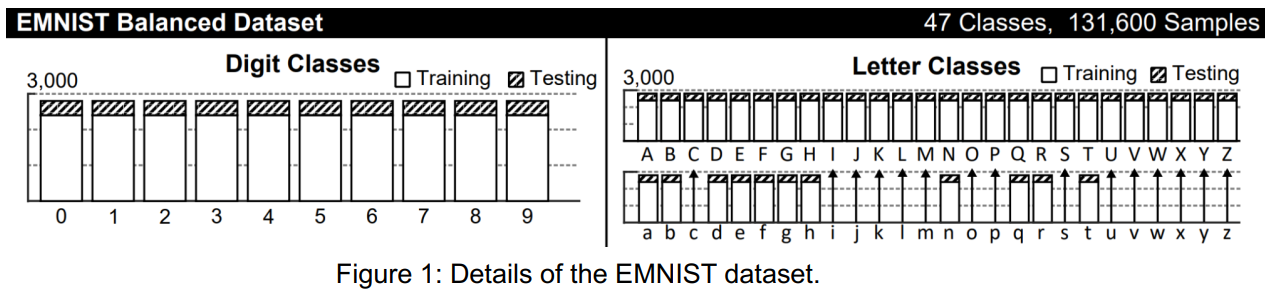

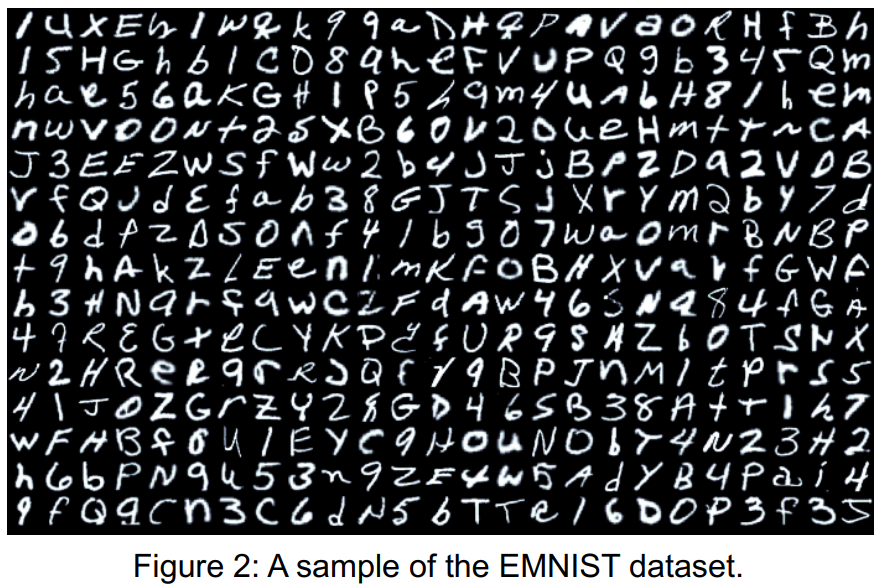

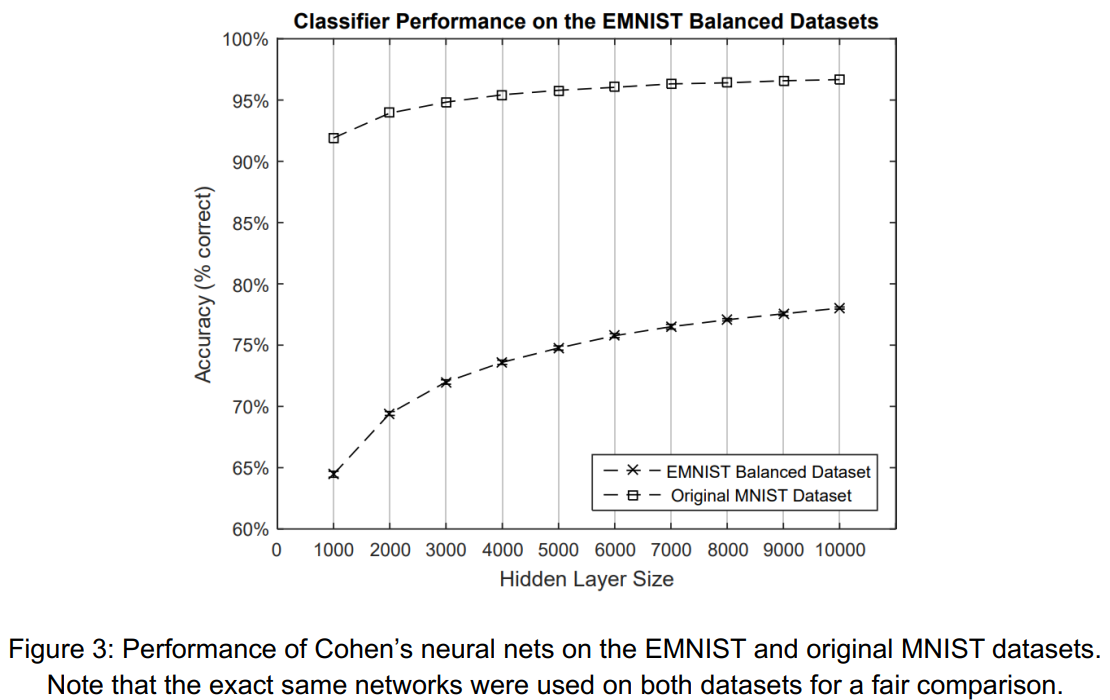

In [2]:
# import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
# split train set from test set
train_set = datasets.EMNIST(
    root='data',
    split='balanced',
    train=True,
    download=True,
    transform=ToTensor()
)

test_set = datasets.EMNIST(
    root='data',
    split='balanced',
    train=False,
    download=True,
    transform=ToTensor()
)

full_train_set = DataLoader(
    train_set,
    shuffle=True)

# make validation split
train_split = int(0.8*len(full_train_set))
val_split = len(full_train_set) - train_split

train_set, val_set = torch.utils.data.random_split(full_train_set.dataset, [train_split, val_split])
print(f'Train size: {train_split}, Val size: {val_split}')

batch_size=64

# train loader and val_loader
train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True)

val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=True)

Train size: 90240, Val size: 22560


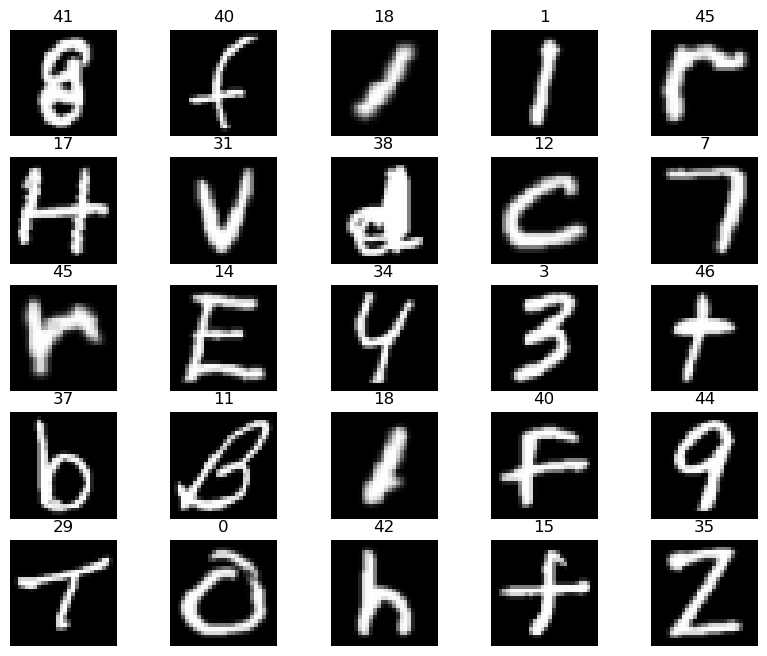

In [5]:
# a small sample of the training set
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.mT.squeeze(), cmap="gray")
plt.show()

In [6]:
# define train loop and test loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [25]:
# define all model architectures to train/test
# INT = Conv2d(in_channels=INT, out_channels=2*INT, kernel_size=3, stride=1, padding='same')
# R = ReLU activation function
# S = Sigmoid activation function
# B = Batch normalization
# D = Dropout(0.2)
# M = Max pooling(kernel_size=2, stride=1)
model_code = {
    'm1': [8, 'R', 'M'],
    'm2': [8, 'S', 'M'],
    'm3': [8, 'B', 'R', 'M'],
    'm4': [8, 'B', 'S', 'M'],
    'm5': [8, 'R', 'M', 16, 'R', 'M'],
    'm6': [8, 'S', 'M', 16, 'S', 'M'],
    'm7': [8, 'B', 'R', 'M', 16, 'B', 'R', 'M'],
    'm8': [8, 'B', 'S', 'M', 16, 'B', 'S', 'M'],
    'm9': [8, 'R', 'M', 'D', 16, 'R', 'M'],
    'm10':[8, 'S', 'M', 'D', 16, 'S', 'M'],
    'm11':[8, 'B', 'R', 'M', 'D', 16, 'B', 'R', 'M'],
    'm12':[8, 'B', 'S', 'M', 'D', 16, 'B', 'S', 'M'],
    'm13':[8, 'R', 'M', 16, 'R', 'M', 32, 'R', 'M'],
    'm14':[8, 'S', 'M', 16, 'S', 'M', 32, 'S', 'M'],
    'm15':[8, 'B', 'R', 'M', 16, 'B', 'R', 'M', 32, 'B', 'R', 'M'],
    'm16':[8, 'B', 'S', 'M', 16, 'B', 'S', 'M', 32, 'B', 'S', 'M'],
    'm17':[8, 'R', 'M', 'D', 16, 'R', 'M', 'D', 32, 'R', 'M'],
    'm18':[8, 'S', 'M', 'D', 16, 'S', 'M', 'D', 32, 'S', 'M'],
    'm19':[8, 'B', 'R', 'M', 'D', 16, 'B', 'R', 'M', 'D', 32, 'R', 'M'],
    'm20':[8, 'B', 'S', 'M', 'D', 16, 'B', 'S', 'M', 'D', 32, 'S', 'M'],
}

models = ['m1', 'm3', 'm5', 'm7', 'm9', 'm11', 'm13']

m1
8
R
M


m2
8
S
M




In [136]:
# define neural net class with easily tunable architecture
class CNN(nn.Module):
    def __init__(self, m, model_code, fc):
        super(CNN, self).__init__()
        # 3 convolutional layers
        # input shape = 28x28
        size_in = 1
        size_shape = 28
        self.layers, size_in, size_shape = self.make_layers(m, model_code, size_in, size_shape)
        if fc == 1:
            self.classifier = nn.Linear(in_features=size_in*size_shape*size_shape, out_features=47)
        elif fc == 2:
            self.classifier = nn.Sequential(nn.Linear(in_features=size_in*size_shape*size_shape, out_features=256),
                                             nn.Linear(in_features=256, out_features=47))
        elif fc == 3:
            self.classifier = nn.Sequential(nn.Linear(in_features=size_in*size_shape*size_shape, out_features=256),
                                             nn.Linear(in_features=256, out_features=128),
                                             nn.Linear(in_features=128, out_features=47))
                             
    def make_layers(self, m, model_code, size_in, size_shape):
        layers = []
        size_out = 8
        for code in model_code[m]:
            if code == 'R':
                layers += [nn.ReLU()]
            elif code == 'S':
                layers += [nn.Sigmoid()]
            elif code == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=1)]
                size_shape -= 1
            elif code == 'B':
                layers += [nn.BatchNorm2d(size_in)]
            elif code == 'D':
                layers += [nn.Dropout(0.2)]
            else:
                layers += [nn.Conv2d(in_channels=size_in, out_channels=size_out, kernel_size=3, stride=1, padding='same')]
                size_in = size_out
                size_out *= 2
                             
        return (nn.Sequential(*layers), size_in, size_shape)
        
    def forward(self, x):
        x = self.layers(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.classifier(x)
        
        return x

In [ ]:
# define which models to train/test
# run train/test loop
models = ['m1', 'm3', 'm5', 'm7', 'm9', 'm11', 'm13']

for m in models:
    for fc in [1, 2, 3]:
        net = CNN(m, model_code, fc)
        for lr in [-2, -2.5, -3, -3.5]:
            learning_rate = 10 ** lr
            for momentum in [0.9, 0.8]:
                epochs = 10
                loss_fn = nn.CrossEntropyLoss()
                optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
                #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                print('model :', m)
                print(net)
                print('learning rate: ', learning_rate)
                print('momentum: ', momentum)
                for t in range(epochs):
                    print(f"Epoch {t+1}\n-------------------------------")
                    train_loop(train_loader, net, loss_fn, optimizer)
                    test_loop(val_loader, net, loss_fn)
                print("Done!")

model : m1
CNN(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=5832, out_features=47, bias=True)
)
learning rate:  0.01
momentum:  0.9
Epoch 1
-------------------------------
loss: 3.842505  [   64/90240]
loss: 1.352348  [ 6464/90240]
loss: 1.474351  [12864/90240]
loss: 0.906108  [19264/90240]
loss: 1.216273  [25664/90240]
loss: 0.899377  [32064/90240]
loss: 1.024704  [38464/90240]
loss: 1.073614  [44864/90240]
loss: 0.981963  [51264/90240]
loss: 0.752102  [57664/90240]
loss: 0.833762  [64064/90240]
loss: 0.578972  [70464/90240]
loss: 0.593929  [76864/90240]
loss: 0.749510  [83264/90240]
loss: 0.535183  [89664/90240]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.697222 

Epoch 2
-------------------------------
loss: 0.500580  [   64/90240]
loss: 0.641406  [ 6464/90240]
loss: 0.917477  [12864/90240]
loss: 

loss: 0.301695  [ 6464/90240]
loss: 0.380855  [12864/90240]
loss: 0.352071  [19264/90240]
loss: 0.195125  [25664/90240]
loss: 0.314469  [32064/90240]
loss: 0.211763  [38464/90240]
loss: 0.402096  [44864/90240]
loss: 0.409053  [51264/90240]
loss: 0.210835  [57664/90240]
loss: 0.121682  [64064/90240]
loss: 0.206613  [70464/90240]
loss: 0.418216  [76864/90240]
loss: 0.178886  [83264/90240]
loss: 0.259155  [89664/90240]
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.546007 

Epoch 6
-------------------------------
loss: 0.134234  [   64/90240]
loss: 0.210446  [ 6464/90240]
loss: 0.313871  [12864/90240]
loss: 0.290667  [19264/90240]
loss: 0.446008  [25664/90240]
loss: 0.393061  [32064/90240]
loss: 0.222273  [38464/90240]
loss: 0.340410  [44864/90240]
loss: 0.360005  [51264/90240]
loss: 0.211831  [57664/90240]
loss: 0.213625  [64064/90240]
loss: 0.258221  [70464/90240]
loss: 0.255476  [76864/90240]
loss: 0.204032  [83264/90240]
loss: 0.374132  [89664/90240]
Test Error: 
 Accuracy: 82.9%, Avg los

loss: 0.159849  [64064/90240]
loss: 0.258016  [70464/90240]
loss: 0.427864  [76864/90240]
loss: 0.152773  [83264/90240]
loss: 0.087719  [89664/90240]
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.590786 

Epoch 10
-------------------------------
loss: 0.143762  [   64/90240]
loss: 0.337359  [ 6464/90240]
loss: 0.148773  [12864/90240]
loss: 0.191289  [19264/90240]
loss: 0.148738  [25664/90240]
loss: 0.245531  [32064/90240]
loss: 0.248519  [38464/90240]
loss: 0.267305  [44864/90240]
loss: 0.224542  [51264/90240]
loss: 0.226769  [57664/90240]
loss: 0.335991  [64064/90240]
loss: 0.191409  [70464/90240]
loss: 0.226215  [76864/90240]
loss: 0.186907  [83264/90240]
loss: 0.126377  [89664/90240]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.594646 

Done!
model : m1
CNN(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features

loss: 0.153876  [51264/90240]
loss: 0.148517  [57664/90240]
loss: 0.179398  [64064/90240]
loss: 0.326766  [70464/90240]
loss: 0.176194  [76864/90240]
loss: 0.090054  [83264/90240]
loss: 0.158715  [89664/90240]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.619275 

Epoch 4
-------------------------------
loss: 0.254835  [   64/90240]
loss: 0.195618  [ 6464/90240]
loss: 0.074747  [12864/90240]
loss: 0.156188  [19264/90240]
loss: 0.301395  [25664/90240]
loss: 0.184038  [32064/90240]
loss: 0.078909  [38464/90240]
loss: 0.086667  [44864/90240]
loss: 0.171742  [51264/90240]
loss: 0.146918  [57664/90240]
loss: 0.108611  [64064/90240]
loss: 0.113270  [70464/90240]
loss: 0.190827  [76864/90240]
loss: 0.181864  [83264/90240]
loss: 0.135932  [89664/90240]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.622004 

Epoch 5
-------------------------------
loss: 0.109065  [   64/90240]
loss: 0.302929  [ 6464/90240]
loss: 0.114063  [12864/90240]
loss: 0.111499  [19264/90240]
loss: 0.180286  [25664/90240]
loss: 

loss: 0.140829  [ 6464/90240]
loss: 0.083817  [12864/90240]
loss: 0.088884  [19264/90240]
loss: 0.079616  [25664/90240]
loss: 0.253590  [32064/90240]
loss: 0.168311  [38464/90240]
loss: 0.134840  [44864/90240]
loss: 0.091375  [51264/90240]
loss: 0.154918  [57664/90240]
loss: 0.146550  [64064/90240]
loss: 0.262827  [70464/90240]
loss: 0.108279  [76864/90240]
loss: 0.150938  [83264/90240]
loss: 0.144542  [89664/90240]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.635153 

Epoch 9
-------------------------------
loss: 0.206588  [   64/90240]
loss: 0.119578  [ 6464/90240]
loss: 0.115482  [12864/90240]
loss: 0.120996  [19264/90240]
loss: 0.076863  [25664/90240]
loss: 0.100821  [32064/90240]
loss: 0.385739  [38464/90240]
loss: 0.127215  [44864/90240]
loss: 0.086889  [51264/90240]
loss: 0.083842  [57664/90240]
loss: 0.076280  [64064/90240]
loss: 0.103660  [70464/90240]
loss: 0.112055  [76864/90240]
loss: 0.191946  [83264/90240]
loss: 0.162040  [89664/90240]
Test Error: 
 Accuracy: 82.9%, Avg los

loss: 0.132777  [ 6464/90240]
loss: 0.094215  [12864/90240]
loss: 0.121629  [19264/90240]
loss: 0.179470  [25664/90240]
loss: 0.176890  [32064/90240]
loss: 0.118983  [38464/90240]
loss: 0.215458  [44864/90240]
loss: 0.077685  [51264/90240]
loss: 0.129083  [57664/90240]
loss: 0.111717  [64064/90240]
loss: 0.133069  [70464/90240]
loss: 0.168284  [76864/90240]
loss: 0.126415  [83264/90240]
loss: 0.187795  [89664/90240]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.644089 

Epoch 3
-------------------------------
loss: 0.135912  [   64/90240]
loss: 0.159759  [ 6464/90240]
loss: 0.195844  [12864/90240]
loss: 0.107460  [19264/90240]
loss: 0.176115  [25664/90240]
loss: 0.091685  [32064/90240]
loss: 0.178948  [38464/90240]
loss: 0.153778  [44864/90240]
loss: 0.103829  [51264/90240]
loss: 0.162851  [57664/90240]
loss: 0.205240  [64064/90240]
loss: 0.071260  [70464/90240]
loss: 0.108901  [76864/90240]
loss: 0.206471  [83264/90240]
loss: 0.118857  [89664/90240]
Test Error: 
 Accuracy: 83.0%, Avg los

loss: 0.749008  [51264/90240]
loss: 0.323211  [57664/90240]
loss: 0.445005  [64064/90240]
loss: 0.403996  [70464/90240]
loss: 0.374291  [76864/90240]
loss: 0.447291  [83264/90240]
loss: 0.435100  [89664/90240]
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.536601 

Epoch 7
-------------------------------
loss: 0.457040  [   64/90240]
loss: 0.412568  [ 6464/90240]
loss: 0.519247  [12864/90240]
loss: 0.291057  [19264/90240]
loss: 0.330002  [25664/90240]
loss: 0.406788  [32064/90240]
loss: 0.262883  [38464/90240]
loss: 0.446263  [44864/90240]
loss: 0.603731  [51264/90240]
loss: 0.291805  [57664/90240]
loss: 0.403051  [64064/90240]
loss: 0.394824  [70464/90240]
loss: 0.382352  [76864/90240]
loss: 0.712717  [83264/90240]
loss: 0.278262  [89664/90240]
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.539602 

Epoch 8
-------------------------------
loss: 0.544617  [   64/90240]
loss: 0.400771  [ 6464/90240]
loss: 0.272850  [12864/90240]
loss: 0.513985  [19264/90240]
loss: 0.266770  [25664/90240]
loss: 

Test Error: 
 Accuracy: 83.3%, Avg loss: 0.572625 

Done!
model : m1
CNN(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=5832, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=47, bias=True)
  )
)
learning rate:  0.0031622776601683794
momentum:  0.9
Epoch 1
-------------------------------
loss: 0.284050  [   64/90240]
loss: 0.105570  [ 6464/90240]
loss: 0.123972  [12864/90240]
loss: 0.378743  [19264/90240]
loss: 0.117181  [25664/90240]
loss: 0.262235  [32064/90240]
loss: 0.091718  [38464/90240]
loss: 0.262197  [44864/90240]
loss: 0.173062  [51264/90240]
loss: 0.221438  [57664/90240]
loss: 0.375926  [64064/90240]
loss: 0.303197  [70464/90240]
loss: 0.200708  [76864/90240]
loss: 0.257956  [83264/90240]
loss: 0.304179  [89664/90240]
Test Error: 
 Accuracy: 83

loss: 0.179601  [44864/90240]
loss: 0.262689  [51264/90240]
loss: 0.164467  [57664/90240]
loss: 0.321779  [64064/90240]
loss: 0.162800  [70464/90240]
loss: 0.090139  [76864/90240]
loss: 0.067570  [83264/90240]
loss: 0.179900  [89664/90240]
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.643334 

Epoch 5
-------------------------------
loss: 0.164586  [   64/90240]
loss: 0.167053  [ 6464/90240]
loss: 0.225277  [12864/90240]
loss: 0.215963  [19264/90240]
loss: 0.158015  [25664/90240]
loss: 0.260524  [32064/90240]
loss: 0.328087  [38464/90240]
loss: 0.078832  [44864/90240]
loss: 0.068856  [51264/90240]
loss: 0.130349  [57664/90240]
loss: 0.110218  [64064/90240]
loss: 0.312899  [70464/90240]
loss: 0.149538  [76864/90240]
loss: 0.127103  [83264/90240]
loss: 0.130438  [89664/90240]
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.643330 

Epoch 6
-------------------------------
loss: 0.058765  [   64/90240]
loss: 0.177068  [ 6464/90240]
loss: 0.180635  [12864/90240]
loss: 0.253087  [19264/90240]
loss: 